# LSTM Time Series Forecasting: Air Pollution in Beijing


## Problem

## Introduction

Time series forecasting involves making predictions about time-dependent variable states based on past conditions. Time series forecasting differs from regression in that there are no entirely independent variables - all variable values are observed in relation to time itself. 

For this project, we will be building what is called a Long Short-Term Memory (LSTM) time series forecasting model. LSTM networks are neural networks that contain architectural elements (LSTM "cells") which retain snapshots of a previous input representations that can be modified through time as new inputs are processed. One way to think of LSTM cell is as a "neural network within a neural network" with three distinct inner segments: (1) a "forget gate" to determine how much of the previous cell state to forget, (2) an "input gate" to determine what and how to modify the current cell representation, (3) an "output gate" to determine the final output representation state of the cell. 

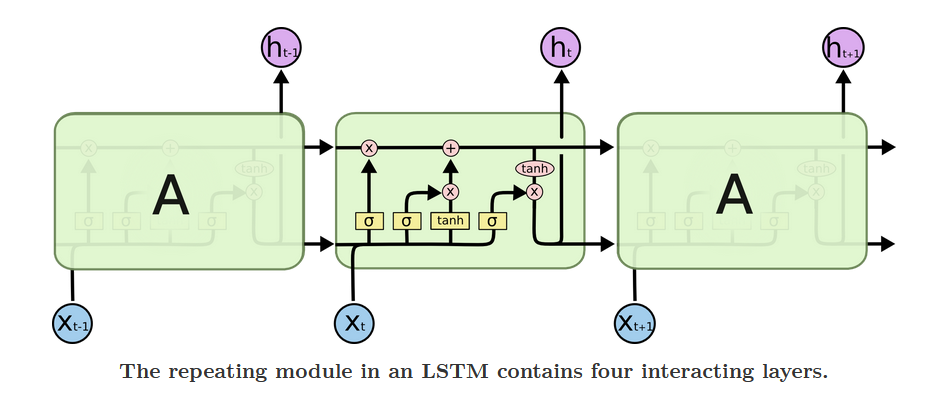


Our LSTM model will be a multivariate model, meaning it will produce predictions based on multiple conditions.


## Exercise Problem Statement

We will be building our LSTM forecasting model to predict the hourly levels of air pollution in Beijing, China given observed weather conditions and past pollution measurements. Up until recently, Beijing has struggled with maintaining its air quality. Of particular challange was lowering level of P

## Dataset

Our project dataset is from the University of California Irving as provided by Liang, et al:

Liang, X., Zou, T., Guo, B., Li, S., Zhang, H., Zhang, S., Huang, H. and Chen, S. X. (2015). Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating. Proceedings of the Royal Society A, 471, 20150257.
https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

Data is inherently meaningless unless mapped in consequential ways. This applies both technically and nontechnically. Below is a table describing the attributes included in this project's dataset (from UCI summary):

| Attribute   | Description |
|:-----------:|:-----------:|
|No| row number
|year| year of data in this row
|month| month of data in this row
|day| day of data in this row
|hour| hour of data in this row
|pm2.5| PM2.5 concentration
|DEWP| Dew Point
|TEMP| Temperature
|PRES| Pressure
|cbwd| Combined wind direction
|Iws| Cumulated wind speed
|Is| Cumulated hours of snow
|Ir| Cumulated hours of rain



## Data Preprocessing

Before we can use our dataset for training our model, we must first assess our dataset's quality and take the necessary steps to optimize its usefulness. To accomplish this, we can use the Pandas library.

In [1]:
import pandas as pd

#Importing raw dataset...
raw_dataset = pd.read_csv('./assets/data/raw_dataset.csv', index_col = 'No')

#Exploring structure...
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 1 to 43824
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    43824 non-null  int64  
 1   month   43824 non-null  int64  
 2   day     43824 non-null  int64  
 3   hour    43824 non-null  int64  
 4   pm2.5   41757 non-null  float64
 5   DEWP    43824 non-null  int64  
 6   TEMP    43824 non-null  float64
 7   PRES    43824 non-null  float64
 8   cbwd    43824 non-null  object 
 9   Iws     43824 non-null  float64
 10  Is      43824 non-null  int64  
 11  Ir      43824 non-null  int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 4.3+ MB


In [2]:
#For formality, searching entire dataset for NA values
na_check = raw_dataset.isnull().values.any()
print(na_check)

True


In [3]:
#For formality, identifying columns with NA values
na_check_cols = raw_dataset.isnull().sum()
print(na_check_cols)

year        0
month       0
day         0
hour        0
pm2.5    2067
DEWP        0
TEMP        0
PRES        0
cbwd        0
Iws         0
Is          0
Ir          0
dtype: int64


In [4]:
#Sample visual of dataset
raw_dataset.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


One common piece of advice I've collected from experienced data science practitioners is that it is important to properly understand NA values before deciding to remove them. From our dataset survey for NAs, we can see that our pm2.5 attribute contains 2,067 missing values - approximately 5% of the total value opportunities. Let's do a bit more exploring to discover how to handle these.

First, let's reform our date and time columns into a more compact and usable format. We can do this by re-importing our raw dataset with some extra parameters. Since we are re-importing, we can also take the opportunity to generate more meaningful column labels.

In [5]:
#Importing datetime to utilize its strptime() string-to-datetime formatter
from datetime import datetime

#Reimporting raw dataset with a single datetime column
df = pd.read_csv("./assets/data/raw_dataset.csv", parse_dates = [['year','month','day','hour']], index_col = 'No')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 1 to 43824
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year_month_day_hour  43824 non-null  object 
 1   pm2.5                41757 non-null  float64
 2   DEWP                 43824 non-null  int64  
 3   TEMP                 43824 non-null  float64
 4   PRES                 43824 non-null  float64
 5   cbwd                 43824 non-null  object 
 6   Iws                  43824 non-null  float64
 7   Is                   43824 non-null  int64  
 8   Ir                   43824 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.3+ MB


In [7]:
#Renaming column headers
df.columns = ['datetime','pm2.5_levels','dew_point','temp','pressure','wind_direction','wind_speed','cum_snow','cum_rain']

#Converting datetime column into datetime format
df['datetime'] = df['datetime'].apply(lambda _: datetime.strptime(_,"%Y %m %d %H"))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 1 to 43824
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        43824 non-null  datetime64[ns]
 1   pm2.5_levels    41757 non-null  float64       
 2   dew_point       43824 non-null  int64         
 3   temp            43824 non-null  float64       
 4   pressure        43824 non-null  float64       
 5   wind_direction  43824 non-null  object        
 6   wind_speed      43824 non-null  float64       
 7   cum_snow        43824 non-null  int64         
 8   cum_rain        43824 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(1)
memory usage: 3.3+ MB


Now that we've formatted our df more appropriately, we are in a better spot to explore our missing pm2.5_level values. To do this, let's create a dataframe of just our missing values and their indexes.

In [8]:
#Isolating missing pm2.5_level values
df_missing = df.drop(df.iloc[:, 2:], axis=1)
#df_missing = df_missing[df_missing['pm2.5_levels'].isnull()]
df_missing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43824 entries, 1 to 43824
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      43824 non-null  datetime64[ns]
 1   pm2.5_levels  41757 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 MB


In [9]:
df_missing.set_index('datetime', inplace = True)

<AxesSubplot:ylabel='datetime'>

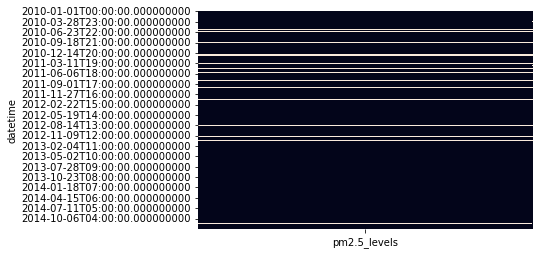

In [10]:
import seaborn as sns
sns.heatmap(df_missing.isnull(), cbar=False)

We can see our missing values are scattered about the dataset with our largest unintterupted interval occuring between the beginning of 2013 into late 2014. We can note the general pattern of missing readings for potential model improvement work in the future.

For now, we can drop the missing readings from the very beginning of the series and interprolate the remaining missing values using a linear function. 

In [11]:
#To see how many initial readings are missing pm2.5 readings
first_valid_index = df['pm2.5_levels'].first_valid_index()

In [12]:
#Trimming and interpolating dataframe
df_scrubbed = df.loc[first_valid_index:,:]
df_scrubbed.head()

,datetime,pm2.5_levels,dew_point,temp,pressure,wind_direction,wind_speed,cum_snow,cum_rain
No,,,,,,,,,
25,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
26,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
27,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
28,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
29,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [13]:
#Suppress warning for interpolate
pd.options.mode.chained_assignment = None

#Interpolate remaining missing pm2.5 values using existing values both prior and after missing points
df_scrubbed.loc[:,'pm2.5_levels'].interpolate(limit_direction="both", inplace=True)

#Setting index to datetime with supressed warning
df_scrubbed.set_index('datetime', inplace = True)

df_scrubbed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pm2.5_levels    43800 non-null  float64
 1   dew_point       43800 non-null  int64  
 2   temp            43800 non-null  float64
 3   pressure        43800 non-null  float64
 4   wind_direction  43800 non-null  object 
 5   wind_speed      43800 non-null  float64
 6   cum_snow        43800 non-null  int64  
 7   cum_rain        43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


Our dataset is now one-step closer for training. Let's save it as a .CSV for safekeeping before continuing to the next step.

In [14]:
df_scrubbed.to_csv('./assets/data/scrubbed_dataset.csv')

Now that our data is scrubbed, we need to form into suitable supervised machine learning format.

## Preparing Data for Supervised Learning

Before we can properly train our LSTM model on our pm2.5 dataset, we'll need to perform some restructuring and normalization.

In [15]:
#from pandas import read_csv
#from pandas import DataFrame
#from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


#load dataset
dataset = pd.read_csv('./assets/data/scrubbed_dataset.csv', header=0, index_col=0)

#Creating a NumPy array from our dataset
values = dataset.to_numpy()

#Encoding our categorical values for wind_direction variable with SKLearn's LableEncoder()
encoder = LabelEncoder()

values[:,4] = encoder.fit_transform(values[:,4])

print(values)





[[129.0 -16 -4.0 ... 1.79 0 0]
 [148.0 -15 -4.0 ... 2.68 0 0]
 [159.0 -11 -5.0 ... 3.57 0 0]
 ...
 [10.0 -22 -3.0 ... 242.7 0 0]
 [8.0 -22 -4.0 ... 246.72 0 0]
 [12.0 -21 -3.0 ... 249.85 0 0]]
